# Our own Embeddings

## Data Load and Exploration

In [1]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("data/dataset.csv", encoding="utf-8")

dataset.head()

,Date_published,Headline,Synopsis,Full_text,Final Status
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive


## Data Cleaning

Let's quickly do all the needed operations

In [2]:
# Convert to binary
dataset.loc[97, "Final Status"] = "Positive"
dataset["Final Status"] = dataset["Final Status"].map({"Positive": 1, "Negative": 0})

In [3]:
# Check  and clean empty Synopsis
dataset[dataset["Synopsis"].isna()].index

Index([56], dtype='int64')

In [4]:
dataset.loc[56, "Synopsis"] = " "

## Preprocessing Text

In [5]:
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer


lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

In [6]:
# replace contractions
def decontracted(phrase):
    phrase = re.sub(r"\'t", "not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [7]:
def preprocess_text(text):
    text = decontracted(text)
    text = re.sub("[^a-zA-Z]", " ", str(text))  # alpha only
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)  # Remove single characters
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces
    
    return text

For our dataset, we will create a corpus with minimal preprocessing (simply removing non-alpha characters and extra white spaces).

Since we only have 3 textual fields, we will join them insto a single field, to make preprocessing easier.

We will save them in a list called corpus.

In [8]:
corpus = []
dataset["processed_article"] = (
    dataset["Headline"] + " " + dataset["Synopsis"] + " " + dataset["Full_text"]
)

# for future use in Lexicons
dataset["full_article"] = (
    dataset["Headline"] + " " + dataset["Synopsis"] + " " + dataset["Full_text"]
)

for i in range(len(dataset["processed_article"])):
    dataset.loc[i, "processed_article"] = preprocess_text(
        dataset["processed_article"][i]
    )
    corpus.append(dataset["processed_article"][i])

In [9]:
corpus[:10]

['Banks holding on to subsidy share say payments firms The companies have written to the National Payments Corp of India NPCI complaining that crore of the crore granted in the budget is being retained by banks ReutersPayments companies and banks are at loggerheads over the sharing of government granted subsidies for building payment infrastructure said three people with knowledge of the matter The companies have written to the National Payments Corp of India NPCI complaining that crore of the crore granted in the budget is being retained by banks they said This has deprived companies connecting up the last mile of state promised revenues according to them The government granted the subsidies in exchange for waiving Merchant Discount Rate MDR charges The government has released crore worth of subsidies to banks but they are not sharing it with any payment aggregators said the CEO of payments company on condition of anonymity Compensation for MDR Waiver We have taken up the matter with 

In [10]:
vocab = set()

for s in corpus:
    vocab.update(s.split())

vocab_size = len(vocab)
print(vocab_size,list(vocab)[:20])

10427 ['Sachin', 'observe', 'any', 'pound', 'relies', 'mayhem', 'intra', 'substitution', 'HDFC', 'Keshav', 'tighter', 'unabated', 'Contain', 'reversing', 'rangeNEW', 'moves', 'either', 'Still', 'mandate', 'Linde']


Using gensim, let's create the documents ready for use with embeddings.
We get 400 documents (articles).

Also, an example of preprocessed document. An article becomes a list of tokens, so our documents object is a list of lists.

In [11]:
import gensim

documents = []
for article in corpus:
    documents.append(gensim.utils.simple_preprocess(article))
print(len(documents),documents[0])

400 ['banks', 'holding', 'on', 'to', 'subsidy', 'share', 'say', 'payments', 'firms', 'the', 'companies', 'have', 'written', 'to', 'the', 'national', 'payments', 'corp', 'of', 'india', 'npci', 'complaining', 'that', 'crore', 'of', 'the', 'crore', 'granted', 'in', 'the', 'budget', 'is', 'being', 'retained', 'by', 'banks', 'reuterspayments', 'companies', 'and', 'banks', 'are', 'at', 'loggerheads', 'over', 'the', 'sharing', 'of', 'government', 'granted', 'subsidies', 'for', 'building', 'payment', 'infrastructure', 'said', 'three', 'people', 'with', 'knowledge', 'of', 'the', 'matter', 'the', 'companies', 'have', 'written', 'to', 'the', 'national', 'payments', 'corp', 'of', 'india', 'npci', 'complaining', 'that', 'crore', 'of', 'the', 'crore', 'granted', 'in', 'the', 'budget', 'is', 'being', 'retained', 'by', 'banks', 'they', 'said', 'this', 'has', 'deprived', 'companies', 'connecting', 'up', 'the', 'last', 'mile', 'of', 'state', 'promised', 'revenues', 'according', 'to', 'them', 'the', 'gov

___
# Word2Vec

In [12]:
from gensim.models import KeyedVectors, Word2Vec

from datetime import datetime

start_time = datetime.now()

model = Word2Vec(
    documents, vector_size=150, window=10, min_count=2, workers=10, sg=1
)

print("Training time:", datetime.now() - start_time)

Training time: 0:00:01.483530


Our dataset is very small (400) so it took only a second to train the model...

Lets save the embeddings (word vectors)

In [13]:
model.wv.save("embeddings/ours_wv")

In [14]:
wv = KeyedVectors.load("embeddings/ours_wv")

lets explore the model

In [15]:
wv.most_similar("good")

[('very', 0.8747538924217224),
 ('bull', 0.8738517761230469),
 ('difficult', 0.8706978559494019),
 ('stage', 0.8673561811447144),
 ('happens', 0.8649054169654846),
 ('find', 0.8645467162132263),
 ('believe', 0.8643554449081421),
 ('different', 0.861832320690155),
 ('understand', 0.8589097857475281),
 ('example', 0.8586216568946838)]

In [16]:
wv.most_similar("bad")

[('recoveries', 0.9714619517326355),
 ('topline', 0.9705643057823181),
 ('cea', 0.9693604111671448),
 ('nims', 0.9689893126487732),
 ('wage', 0.9638749957084656),
 ('moodys', 0.963218629360199),
 ('picking', 0.9620102643966675),
 ('collected', 0.9618736505508423),
 ('restructured', 0.9616324305534363),
 ('restores', 0.9615413546562195)]

In [17]:
wv.most_similar("profit")

[('net', 0.938105583190918),
 ('latest', 0.9155563712120056),
 ('ago', 0.8983212113380432),
 ('loss', 0.8859993815422058),
 ('quarter', 0.8830128312110901),
 ('ag', 0.8744868040084839),
 ('corresponding', 0.8658978343009949),
 ('standalone', 0.857894778251648),
 ('nii', 0.8530405163764954),
 ('reported', 0.8522555828094482)]

In [18]:
wv.most_similar("loss")

[('standalone', 0.9047964811325073),
 ('net', 0.9028610587120056),
 ('rationale', 0.9007294774055481),
 ('clocked', 0.8936715722084045),
 ('aum', 0.8933641910552979),
 ('revenues', 0.8920599818229675),
 ('profit', 0.8859995007514954),
 ('nii', 0.8848789930343628),
 ('vs', 0.8776528239250183),
 ('ag', 0.8741598129272461)]

In [19]:
def text_to_mean_vector(embeddings, text):
    tokens = text.split()
    vectors = []

    for token in tokens:
        try:
            vector = embeddings.get_vector(token)
            vectors.append(vector)
        except KeyError:
            pass  # ignore out-of-vocabulary tokens

    mean_vector = np.mean(vectors, axis=0)

    return mean_vector

In [20]:
mean_embeddings_corpus = []
for c in corpus:
    mean_embeddings_corpus.append(text_to_mean_vector(model.wv, c))

X = np.array(mean_embeddings_corpus)
y = dataset["Final Status"]


print(X.shape, y.shape)

(400, 150) (400,)


In [21]:
from sklearn.model_selection import (
    train_test_split,
    ParameterGrid,
    GridSearchCV,
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

(320, 150) (320,)
(80, 150) (80,)

Label distribution in the training set:
Final Status
1    176
0    144
Name: count, dtype: int64

Label distribution in the test set:
Final Status
0    40
1    40
Name: count, dtype: int64


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [23]:
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(),
    "Multi-Layer Perceptron": MLPClassifier(),
    "XGBoost": XGBClassifier(),
}

In [24]:
def evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

In [25]:
best_params_so_far = {
    "Logistic Regression": {
        "C": 10.0,
        "max_iter": 1000,
        "penalty": "l1",
        "solver": "liblinear",
    },
    "Decision Tree": {
        "criterion": "entropy",
        "max_depth": 20,
        "min_samples_leaf": 4,
        "min_samples_split": 2,
    },
    "Random Forest": {
        "max_depth": None,
        "min_samples_leaf": 2,
        "min_samples_split": 5,
        "n_estimators": 300,
    },
    "SVC": {"C": 10.0, "gamma": "scale", "kernel": "sigmoid"},
    "Multi-Layer Perceptron": {
        "activation": "identity",
        "alpha": 0.01,
        "early_stopping": True,
        "hidden_layer_sizes": (25, 25, 25),
        "max_iter": 500,
        "n_iter_no_change": 10,
    },
    "XGBoost": {
        "learning_rate": 0.01,
        "max_depth": 6,
        "n_estimators": 200,
        "subsample": 0.8,
    },
}

In [26]:
best_params = best_params_so_far

In [27]:
classifiers_tuned = {
    "Logistic Regression": LogisticRegression(**best_params["Logistic Regression"]),
    "Decision Tree": DecisionTreeClassifier(**best_params["Decision Tree"]),
    "Random Forest": RandomForestClassifier(**best_params["Random Forest"]),
    "SVC": SVC(**best_params["SVC"]),
    "Multi-Layer Perceptron": MLPClassifier(**best_params["Multi-Layer Perceptron"]),
    "XGBoost": XGBClassifier(**best_params["XGBoost"]),
}

In [28]:
evaluations = {
    classifier_name: evaluate_classifier(classifier, X_train, y_train, X_test, y_test)
    for classifier_name, classifier in classifiers_tuned.items()
}

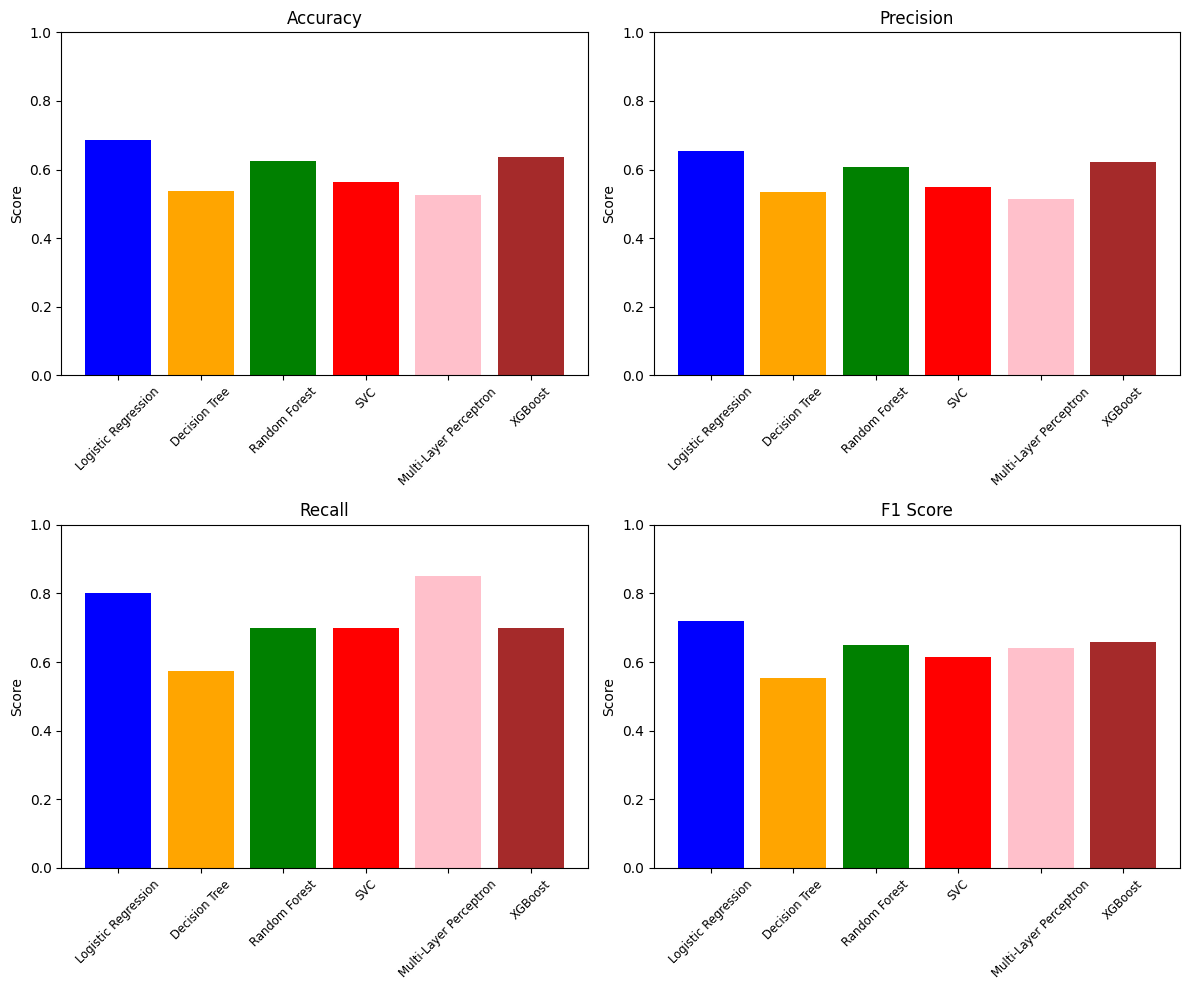

Classifier: Logistic Regression
Accuracy: 0.69
Precision: 0.65
Recall: 0.80
F1 Score: 0.72
------------------------------
Classifier: Decision Tree
Accuracy: 0.54
Precision: 0.53
Recall: 0.57
F1 Score: 0.55
------------------------------
Classifier: Random Forest
Accuracy: 0.62
Precision: 0.61
Recall: 0.70
F1 Score: 0.65
------------------------------
Classifier: SVC
Accuracy: 0.56
Precision: 0.55
Recall: 0.70
F1 Score: 0.62
------------------------------
Classifier: Multi-Layer Perceptron
Accuracy: 0.53
Precision: 0.52
Recall: 0.85
F1 Score: 0.64
------------------------------
Classifier: XGBoost
Accuracy: 0.64
Precision: 0.62
Recall: 0.70
F1 Score: 0.66
------------------------------


In [29]:
import matplotlib.pyplot as plt

metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

colors = ["blue", "orange", "green", "red", "pink", "brown", "purple"]

for i, metric in enumerate(metrics_names):
    row = i // 2
    col = i % 2
    scores = [evaluation[i] for evaluation in evaluations.values()]
    axs[row, col].bar(classifiers.keys(), scores, color=colors)
    axs[row, col].set_title(metric)
    axs[row, col].set_ylabel("Score")
    axs[row, col].set_ylim([0, 1])
    axs[row, col].tick_params(axis="x", labelrotation=45, labelsize="small")

plt.tight_layout()
plt.show()

for classifier_name, metrics in evaluations.items():
    print(f"Classifier: {classifier_name}")
    print(f"Accuracy: {metrics[0]:.2f}")
    print(f"Precision: {metrics[1]:.2f}")
    print(f"Recall: {metrics[2]:.2f}")
    print(f"F1 Score: {metrics[3]:.2f}")
    print("-" * 30)

Altough not bad, the vector space doesn't capture well the relations between words.

___

# Using Lexicons

We will use different general purpose lexicons, and leverage them to perform unsupervised sentiment analysis, and compare the results. Also, we will use a domain-specific [lexicon](https://sraf.nd.edu/loughranmcdonald-master-dictionary/).

The best performing one, will be used to create an extra feature to add to our data, and verify if it improves the traiend classifier models accuracy.

## VADER Sentiment

In [30]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

Use full_article field, which is a composition of the 3 article fields without applying preprocessing techniques.

In [31]:
vader_pred = []
for article in dataset["full_article"]:
    vader_pred.append(1 if analyzer.polarity_scores(article)['compound'] > 0 else 0)

In [32]:
print("Accuracy: ", accuracy_score(y, vader_pred))
print("Precision: ", precision_score(y, vader_pred))
print("Recall: ", recall_score(y, vader_pred))
print("F1: ", f1_score(y, vader_pred))

Accuracy:  0.595
Precision:  0.572972972972973
Recall:  0.9814814814814815
F1:  0.7235494880546075


## Afinn Sentiment

In [33]:
from afinn import Afinn

afn = Afinn()

In [34]:
scores = [afn.score(article) for article in dataset["full_article"]]
sentiment = [
    "positive" if score >= 0 else "negative"
    for score in scores
]

afinn_pred = []
for article in dataset["full_article"]:
    afinn_pred.append(1 if afn.score(article) > 0 else 0)

In [35]:
print("Accuracy: ", accuracy_score(y, afinn_pred))
print("Precision: ", precision_score(y, afinn_pred))
print("Recall: ", recall_score(y, afinn_pred))
print("F1: ", f1_score(y, afinn_pred))

Accuracy:  0.6025
Precision:  0.5785123966942148
Recall:  0.9722222222222222
F1:  0.7253886010362695


## SentiWordNet

In [36]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize

# nltk.download("sentiwordnet")
# nltk.download("wordnet")
# nltk.download("averaged_perceptron_tagger")


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith("J"):
        return wn.ADJ
    elif treebank_tag.startswith("V"):
        return wn.VERB
    elif treebank_tag.startswith("N"):
        return wn.NOUN
    elif treebank_tag.startswith("R"):
        return wn.ADV
    else:
        return None


def calculate_sentiment_score(text):
    sentiment_positive = 0.0
    sentiment_negative = 0.0
    article_count = 0

    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    for word, pos_tag in pos_tags:
        wordnet_pos = get_wordnet_pos(pos_tag)
        if wordnet_pos:
            synsets = wn.synsets(word, pos=wordnet_pos)
            if synsets:
                chosen_synset = synsets[0]
                senti_synset = swn.senti_synset(chosen_synset.name())
                sentiment_positive += senti_synset.pos_score()
                sentiment_negative += senti_synset.neg_score()
                article_count += 1

    if article_count > 0:
        final_sentiment = 1 if sentiment_positive > sentiment_negative else 0
    else:
        final_sentiment = None

    return final_sentiment


sentiwordnet_pred = []
for article in dataset["full_article"]:
    sentiment = calculate_sentiment_score(article)
    sentiwordnet_pred.append(sentiment)

In [37]:
print("Accuracy: ", accuracy_score(y, sentiwordnet_pred))
print("Precision: ", precision_score(y, sentiwordnet_pred))
print("Recall: ", recall_score(y, sentiwordnet_pred))
print("F1: ", f1_score(y, sentiwordnet_pred))

Accuracy:  0.6225
Precision:  0.6101694915254238
Recall:  0.8333333333333334
F1:  0.7045009784735812


## Loughran McDonald Master Dictionary

A domain-specific lexicon, altered to better fit the problem at hand (converted to a binary classification problem. Explained in [prepare_lexicon](data/prepare_lexicon.ipynb) notebook).

In [38]:
loughran_mcdonald = pd.read_csv("data/loughran-mcdonald-lexicon.csv")
loughran_mcdonald.head()

,Word,Sentiment
0,abandon,0
1,abandoned,0
2,abandoning,0
3,abandonment,0
4,abandonments,0


In [39]:
def calculate_sentiment_score(article, lexicon):
    words = article.lower().split()
    positive_score = 0
    negative_score = 0
    for word in words:
        if word in lexicon["Word"].values:
            sentiment = lexicon.loc[lexicon["Word"] == word, "Sentiment"].values[0]
            if sentiment == 1:
                positive_score += 1
            elif sentiment == 0:
                negative_score += 1
    if positive_score > negative_score:
        return 1 
    else:
        return 0  

In [40]:
loughran_mcdonald_preds = dataset["full_article"].apply(
    lambda x: calculate_sentiment_score(x, loughran_mcdonald)
)

In [41]:
print("Accuracy: ", accuracy_score(y, loughran_mcdonald_preds))
print("Precision: ", precision_score(y, loughran_mcdonald_preds))
print("Recall: ", recall_score(y, loughran_mcdonald_preds))
print("F1: ", f1_score(y, loughran_mcdonald_preds))

Accuracy:  0.5475
Precision:  0.7464788732394366
Recall:  0.24537037037037038
F1:  0.3693379790940767


Even tought this lexicon was domain specific, it probably wasn't comprehensive enough, or it didn't contined the key termes deemed necessary to accuratly predict sentiment.

___

As we can see, SentiWordNet was the best in classifying sentiment, lets use it to add labels to the dataset, and re-apply our classifier

In [42]:
dataset["sentiwordnet_pred"] = sentiwordnet_pred

In [43]:
sentiword_preds = np.array(dataset["sentiwordnet_pred"]).reshape(-1, 1)

In [44]:
X2 = X.copy()
X2 = np.hstack((X2, sentiword_preds))

In [45]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y, test_size=0.2, random_state=42
)

print(X_train2.shape, y_train2.shape)
print(X_test2.shape, y_test2.shape)

print("\nLabel distribution in the training set:")
print(y_train2.value_counts())

print("\nLabel distribution in the test set:")
print(y_test2.value_counts())

(320, 151) (320,)
(80, 151) (80,)

Label distribution in the training set:
Final Status
1    176
0    144
Name: count, dtype: int64

Label distribution in the test set:
Final Status
0    40
1    40
Name: count, dtype: int64


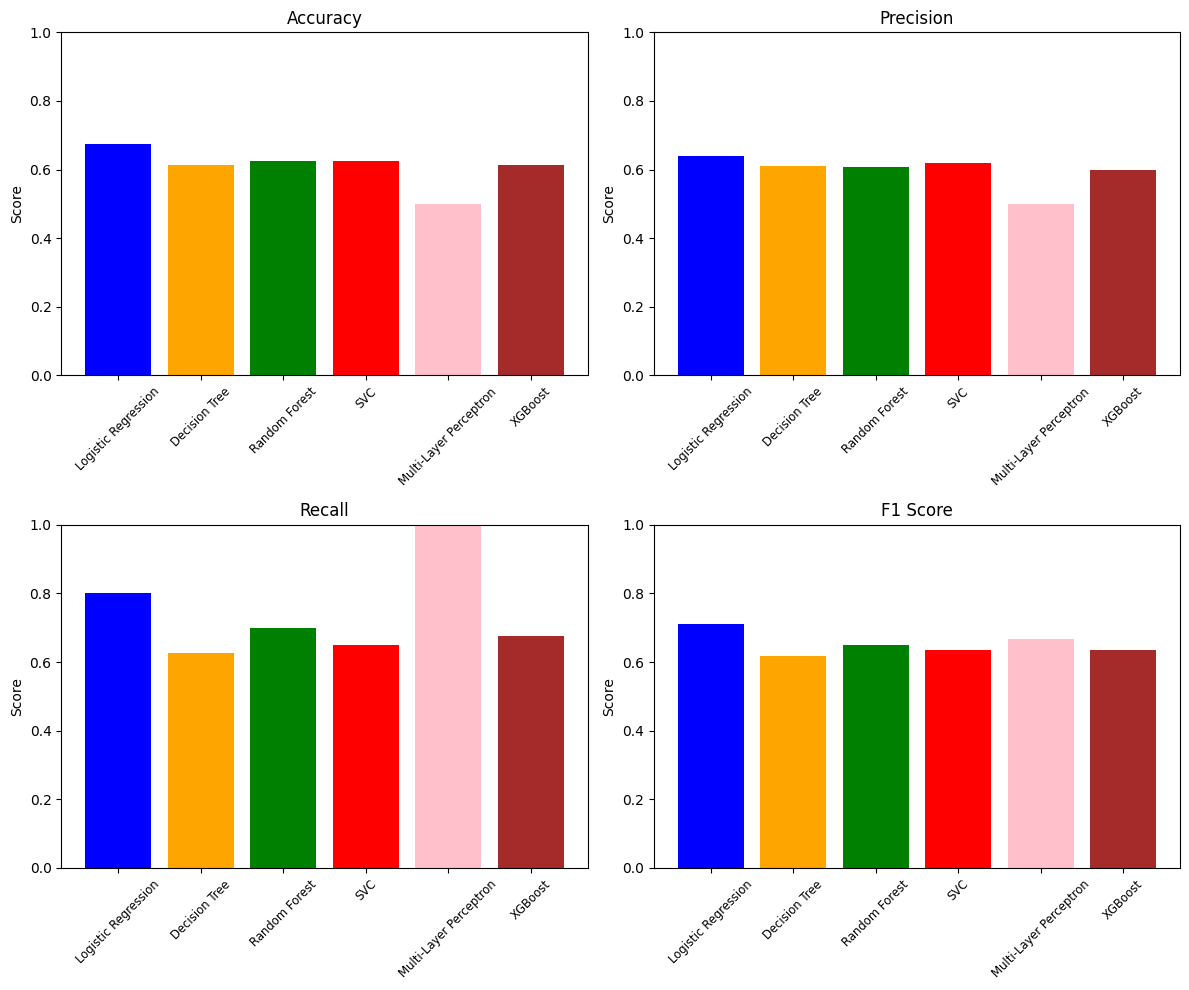

Classifier: Logistic Regression
Accuracy: 0.68
Precision: 0.64
Recall: 0.80
F1 Score: 0.71
------------------------------
Classifier: Decision Tree
Accuracy: 0.61
Precision: 0.61
Recall: 0.62
F1 Score: 0.62
------------------------------
Classifier: Random Forest
Accuracy: 0.62
Precision: 0.61
Recall: 0.70
F1 Score: 0.65
------------------------------
Classifier: SVC
Accuracy: 0.62
Precision: 0.62
Recall: 0.65
F1 Score: 0.63
------------------------------
Classifier: Multi-Layer Perceptron
Accuracy: 0.50
Precision: 0.50
Recall: 1.00
F1 Score: 0.67
------------------------------
Classifier: XGBoost
Accuracy: 0.61
Precision: 0.60
Recall: 0.68
F1 Score: 0.64
------------------------------


In [46]:
evaluations2 = {
    classifier_name: evaluate_classifier(classifier, X_train2, y_train2, X_test2, y_test2)
    for classifier_name, classifier in classifiers_tuned.items()
}
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

colors = ["blue", "orange", "green", "red", "pink", "brown", "purple"]

for i, metric in enumerate(metrics_names):
    row = i // 2
    col = i % 2
    scores = [evaluation[i] for evaluation in evaluations2.values()]
    axs[row, col].bar(classifiers.keys(), scores, color=colors)
    axs[row, col].set_title(metric)
    axs[row, col].set_ylabel("Score")
    axs[row, col].set_ylim([0, 1])
    axs[row, col].tick_params(axis="x", labelrotation=45, labelsize="small")

plt.tight_layout()
plt.show()

for classifier_name, metrics in evaluations2.items():
    print(f"Classifier: {classifier_name}")
    print(f"Accuracy: {metrics[0]:.2f}")
    print(f"Precision: {metrics[1]:.2f}")
    print(f"Recall: {metrics[2]:.2f}")
    print(f"F1 Score: {metrics[3]:.2f}")
    print("-" * 30)

___

## Final Evaluation

In [47]:
max_name_length = max(len(name) for name in evaluations.keys() | evaluations2.keys())

print(
    f"{'Classifier Accuracy':<{max_name_length}} {'Base':<25} {'+Lexicon Features':<25}"
)
print("-" * (max_name_length + 60)) 

for classifier_name in sorted(set(evaluations.keys()) | set(evaluations2.keys())):
    accuracy_evaluations = evaluations.get(classifier_name, (0,))[0]
    accuracy_evaluations2 = evaluations2.get(classifier_name, (0,))[0]
    print(
        f"{classifier_name:<{max_name_length}} {accuracy_evaluations:.2f} {' ' * 10} {accuracy_evaluations2:.2f}"
    )

Classifier Accuracy    Base                      +Lexicon Features        
----------------------------------------------------------------------------------
Decision Tree          0.54            0.61
Logistic Regression    0.69            0.68
Multi-Layer Perceptron 0.53            0.50
Random Forest          0.62            0.62
SVC                    0.56            0.62
XGBoost                0.64            0.61


As we can see, using a Lexicon's sentiment predictions did not improve most of our classifiers.

This poor performance relative to using lexicons with sparse vectors could be related to the way features are represented, and simply joining the predictions to the vectors won't be beneficial, since we are adding explicit knowledge and meaning to implicit (semntatic) context.

It's better to not use it.

___

## Visualization

In [49]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def reduce_dimensions(model, num_dimensions=3, words=[], perplexity=None):
    vectors = np.array([model.wv.get_vector(word) for word in words])

    if perplexity is None:
        perplexity = min(30, len(vectors) - 1)

    tsne = TSNE(n_components=num_dimensions, perplexity=perplexity, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)

    return reduced_vectors, words


def visualize_embeddings(
    x_vals,
    y_vals,
    z_vals,
    labels,
    point_size=10,
    point_color="blue",
    label_color="black",
    label_size=10,
):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    for i, label in enumerate(labels):
        x = x_vals[i]
        y = y_vals[i]
        z = z_vals[i]
        ax.scatter(x, y, z, s=point_size, c=point_color, marker="o")
        ax.text(x, y, z, label, color=label_color, size=label_size)
    plt.show()

In [50]:
keys = [
    "profit",
    "investment",
    "finance",
    "shares",
    "risk",
    "assets",
    "liability",
    "credit",
    "capital",
    "exposure",
    "tax",
]

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

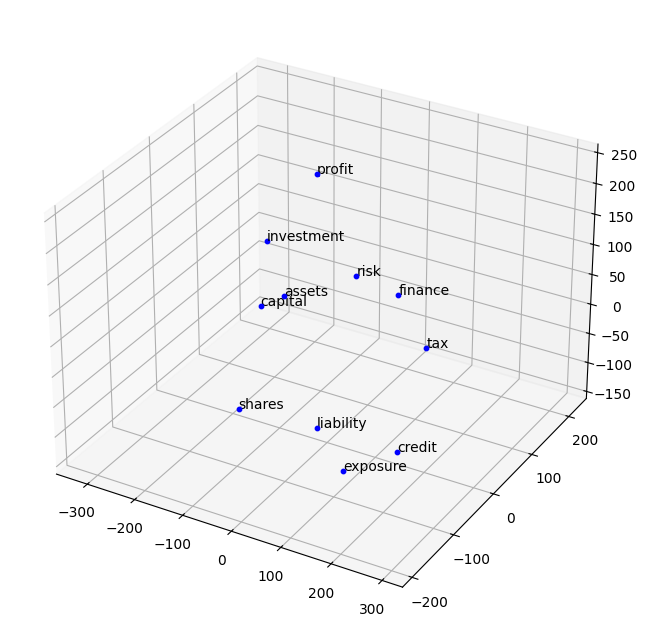

In [51]:
reduced_embeddings, words_to_visualize = reduce_dimensions(
    model, num_dimensions=3, words=keys
)
visualize_embeddings(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    reduced_embeddings[:, 2],
    words_to_visualize
)

In [52]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(
    perplexity=15, n_components=2, init="pca", n_iter=2500, random_state=32
)
embeddings_en_2d = np.array(
    tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
).reshape(n, m, 2)

/var/folders/7h/1vqhnhpx2gl_zc8_6pj32nz80000gn/T/ipykernel_69877/3042592960.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=color, alpha=a, label=label)


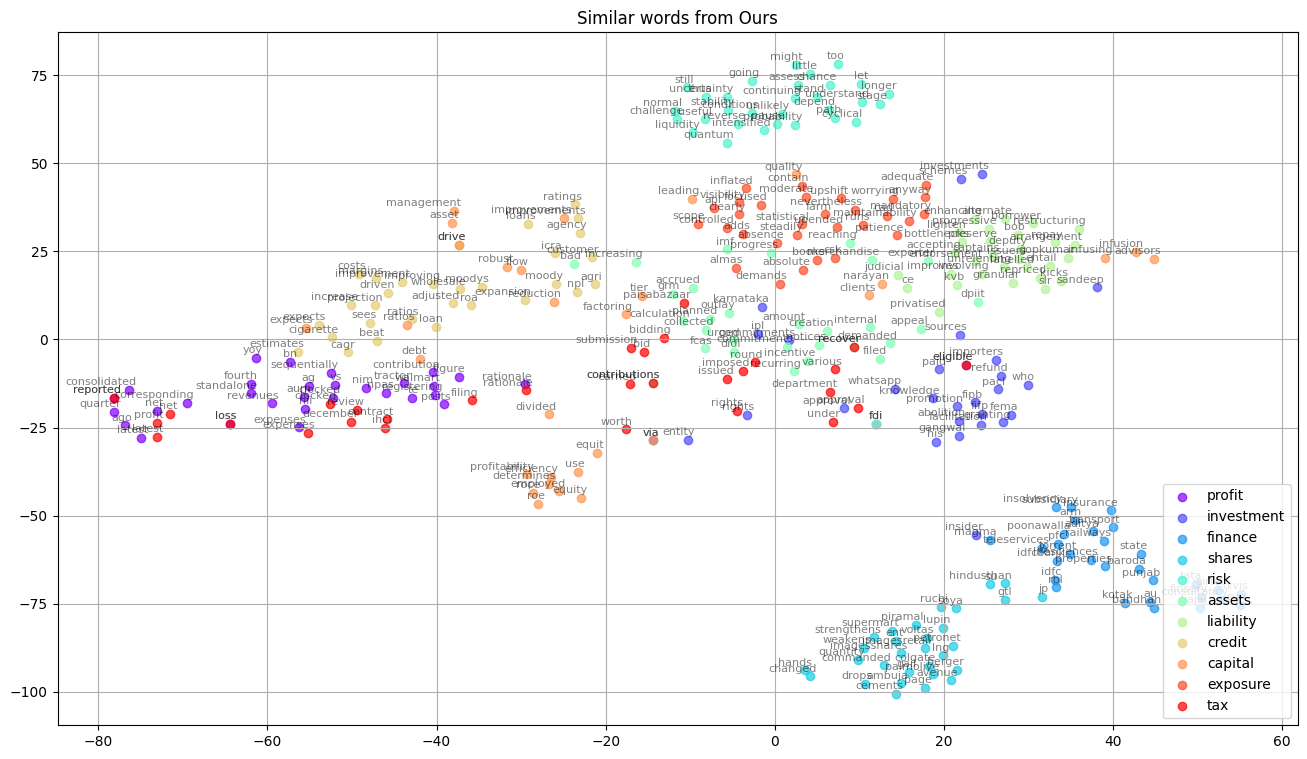

In [53]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Ours', keys, embeddings_en_2d, word_clusters, 0.7,
                        'figs/ours.png')